# Entrega Final - Data Science III

# Proyecto: Clasificación de Sentimiento de Reseñas (Rotten Tomatoes)

# Autor: Franco Allemandi

# 1. Descripción del problema de negocio


Se busca clasificar reseñas de películas en positivas o negativas usando técnicas de Procesamiento de Lenguaje Natural (NLP) y un modelo de aprendizaje supervisado (Regresión Logística). Esto puede ayudar a empresas a medir la satisfacción de usuarios, priorizar moderación o detectar tendencias en productos.

# 2. Objetivo general

Construir un pipeline reproducible que incluya:
* Preprocesamiento de texto (limpieza, tokenización y lematización)
* Análisis exploratorio de texto (frecuencias, n-gramas, nubes de palabras)
* Vectorización (TF-IDF)
* Entrenamiento y evaluación de un clasificador (Regresión Logística)

# 3. Origen de los datos

## Dataset: rotten_tomatoes_movie_reviews.csv
Numerosos sitios web albergan datos relacionados con el cine, pero Rotten Tomatoes destaca como la plataforma líder para las críticas de la crítica. El sitio permite a los usuarios comparar las puntuaciones otorgadas por el público general (puntuación de la audiencia) con las calificaciones proporcionadas por críticos profesionales (Tomatómetro), quienes son miembros acreditados de diversos gremios de escritores u organizaciones de críticos de cine.
Se han generado dos archivos .csv, uno con 10.000 reseñas y el otro con 50.000, de tal manera de que el usuario tenga la posibilidad de probar ambos. Cada registro representa una reseña de un crítico publicada en Rotten Tomatoes, que incluye todos los campos disponibles en el sitio web.

Columnas relevantes:
id, reviewId, creationDate, criticName, isTopCritic, originalScore, reviewState, publicatioName, reviewText, scoreSentiment, reviewUrl.
Se usarán `reviewText` como texto y `scoreSentiment` como etiqueta.

# 4. Librerías a utilizar

In [11]:
try:
  import sklearn
except Exception:
  !pip install -q scikit-learn
  !pip install -q pandas numpy matplotlib seaborn
  !pip install -q nltk spacy
  !pip install -q wordcloud
  !pip install -q vaderSentiment
  !python -m spacy download en_core_web_sm

## Importación librerías

In [12]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import spacy
nlp = spacy.load('en_core_web_sm') # modelo inglés para lematización

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 5. Carga y preparación de los datos

In [13]:
# Bucle que pregunta hasta que el usuario elija usar el dataset de 10.000 o 50.000 reseñas
while True:
    opcion = input("Elegí una opción: '1' para dataset con 10k reviews (menor tiempo de procesamiento) o '2' para dataset con 50k reviews (aproximadamente 5-10 minutos de preprocesamiento)")

    if opcion == "1":
        print("Elegiste el dataset de 10k reviews")
        url = 'https://raw.githubusercontent.com/franallemandi/curso_data_science_3/refs/heads/main/rotten_tomatoes_movie_reviews_10000.csv'
        break
    elif opcion == "2":
        print("Elegiste el dataset de 50k reviews")
        url = 'https://raw.githubusercontent.com/franallemandi/curso_data_science_3/refs/heads/main/rotten_tomatoes_movie_reviews_50000.csv'
        break
    else:
        print("Opción no válida. Por favor, elegí 1 o 2.\n")

#Se carga el dataset desde un repositorio público en GitHub
try:
    df = pd.read_csv(url, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(url, encoding='latin1')
print('Dimensiones del dataset:', df.shape)
print('\nColumnas del dataset:', list(df.columns))
df.head()

Elegí una opción: '1' para dataset con 10k reviews (menor tiempo de procesamiento) o '2' para dataset con 50k reviews (aproximadamente 5-10 minutos de preprocesamiento)1
Elegiste el dataset de 10k reviews
Dimensiones del dataset: (9999, 11)

Columnas del dataset: ['id', 'reviewId', 'creationDate', 'criticName', 'isTopCritic', 'originalScore', 'reviewState', 'publicatioName', 'reviewText', 'scoreSentiment', 'reviewUrl']


,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,diary_of_a_mad_black_woman,1,3/4/2005,James Rocchi,False,5-Jan,rotten,Netflix,"Sloppy, insipid mishmash of female empowerment...",NEGATIVE,http://www.netflix.com/MovieDisplay?movieid=70...
1,the_burbs,2,1/1/2000,Hal Hinson,True,NaN,rotten,Washington Post,Why is it not funny? It's just not. Not remote...,NEGATIVE,http://www.washingtonpost.com/wp-srv/style/lon...
2,the_burbs,3,1/1/2000,Desson Thomson,True,NaN,rotten,Washington Post,Although it initially flares up on high-concep...,NEGATIVE,http://www.washingtonpost.com/wp-srv/style/lon...
3,10,17,1/1/2000,Tim Dirks,False,NaN,fresh,Filmsite,10 (1979) is known for its numerical rating sy...,POSITIVE,http://www.filmsite.org/ten.html
4,1000013_12_angry_men,24,1/1/2000,Urban Cinefile Critics,False,NaN,fresh,Urban Cinefile,"A film with texture, humour and relevance at a...",POSITIVE,http://www.urbancinefile.com.au/home/view.asp?...


## Conversión de la variable objetivo a binaria

In [14]:
# Eliminación de columnas innecesarias
df = df[['reviewText','scoreSentiment']]

# Eliminación de filas vacías
df = df.dropna()

print('Dimensiones del dataset:', df.shape)
print('\nColumnas del dataset:', list(df.columns))
df.head()

# Ver valores únicos en scoreSentiment
print('\nValores únicos en scoreSentiment (preview):')
print(df['scoreSentiment'].dropna().unique()[:50])

# Función para convertir a binario
def map_to_binary(label):
  if pd.isna(label):
    return None
# Si ya es texto y contiene 'pos' o 'neg'
  s = str(label).strip().lower()
  if s in ['positive', 'pos', 'p', '1', 'positive ']:
    return 1
  if s in ['negative', 'neg', 'n', '0', 'negative ']:
    return 0

# Aplicación de mapeo
df['label'] = df['scoreSentiment'].apply(map_to_binary)
print('\nConteo labels (incluye posibles None):')
print(df['label'].value_counts(dropna=False))


# Si hay valores None (neutros o no clasificados), se eliminan para el objetivo binario
initial_len = len(df)
df = df[df['label'].notna()].copy()
print(f'Filas removidas por etiqueta no binaria/neutra: {initial_len - len(df)}')


# Conversión label a int
df['label'] = df['label'].astype(int)


# Confirmación
print('\nDistribución final de clases:')
print(df['label'].value_counts())

Dimensiones del dataset: (8210, 2)

Columnas del dataset: ['reviewText', 'scoreSentiment']

Valores únicos en scoreSentiment (preview):
['NEGATIVE' 'POSITIVE']

Conteo labels (incluye posibles None):
label
1    5235
0    2975
Name: count, dtype: int64
Filas removidas por etiqueta no binaria/neutra: 0

Distribución final de clases:
label
1    5235
0    2975
Name: count, dtype: int64


# 6. Preprocesamiento de texto

In [15]:
# Pasos:
# - quitar html y urls
# - quitar caracteres no alfabéticos
# - pasar a minúsculas
# - lematizar con spaCy
# - remover stopwords
URL_PATTERN = r'https?://\S+|www\.\S+'
HTML_TAGS = r'<.*?>'
NON_ALPHANUM = r'[^a-zA-Z\s]'

stop_eng = set(stopwords.words('english'))

# Se reescriben las palabras con contracciones, para un procesamiento más limpio
contractions = {
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "won't": "will not",
    "wouldn't": "would not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "can't": "cannot",
    "couldn't": "could not",
    "shouldn't": "should not",
    "mustn't": "must not",
    "mightn't": "might not",
    "shan't": "shall not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

#========================================================================================
# Definición de funciones para preprocesamiento de texto

def expand_contractions(text):
    text = text.lower()
    for contraction, expanded in contractions.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", expanded, text)
    return text

def clean_text(text):
  if pd.isna(text):
    return ''
  text = re.sub(HTML_TAGS, ' ', str(text))
  text = re.sub(URL_PATTERN, ' ', text)
  text = re.sub(NON_ALPHANUM, ' ', text)
  text = text.lower()
  text = re.sub('\s+', ' ', text).strip()
  return text

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_.isalpha()
    ]
    return ' '.join(lemmas)
#=======================================================================================

print('Procesando texto...')
print('Expandiendo contracciones')
df['expanded_review'] = df['reviewText'].dropna().astype(str).apply(expand_contractions)
print('Aplicando limpieza y lematización. Esto puede tardar varios minutos en ~50k filas...')
print('Limpiando texto...')
df['clean_review'] = df['expanded_review'].astype(str).apply(clean_text)
print('Lematizando texto...')
# Para acelerar, se procesa en batches pequeños y se muestra el progreso al usuario
lemmas = []
batch_size = 2000
total = len(df)
for start in range(0, total, batch_size):
  end = min(start+batch_size, total)
  batch = df['clean_review'].iloc[start:end].tolist()
  batch_lemmas = [lemmatize_text(t) for t in batch]
  lemmas.extend(batch_lemmas)
  print(f'Procesadas filas {start} a {end}...')
df['lemma_review'] = lemmas
print('Preprocesamiento completado.')

# Mostrar ejemplos
for i in range(3):
  print('\nORIGINAL:')
  print(df.iloc[i]['reviewText'][:300])
  print('\nLIMPIO:')
  print(df.iloc[i]['clean_review'][:300])
  print('\nLEMATIZADO:')
  print(df.iloc[i]['lemma_review'][:300])

Procesando texto...
Expandiendo contracciones


<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2137565374.py:59: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text).strip()


Aplicando limpieza y lematización. Esto puede tardar varios minutos en ~50k filas...
Limpiando texto...
Lematizando texto...
Procesadas filas 0 a 2000...
Procesadas filas 2000 a 4000...
Procesadas filas 4000 a 6000...
Procesadas filas 6000 a 8000...
Procesadas filas 8000 a 8210...
Preprocesamiento completado.

ORIGINAL:
Sloppy, insipid mishmash of female empowerment, Christian thought and gun-and-weed jokes is an early front-runner for Worst Film of 2005.

LIMPIO:
sloppy insipid mishmash of female empowerment christian thought and gun and weed jokes is an early front runner for worst film of

LEMATIZADO:
sloppy insipid mishmash female empowerment christian thought gun weed joke early runner bad film

ORIGINAL:
Why is it not funny? It's just not. Not remotely, momentarily, intermittently or otherwise funny.

LIMPIO:
why is it not funny it is just not not remotely momentarily intermittently or otherwise funny

LEMATIZADO:
funny remotely momentarily intermittently funny

ORIGINAL:
Althoug

# 7. Análisis exploratorio y visualizaciones

count    8210.000000
mean       20.862850
std        10.064039
min         1.000000
25%        13.000000
50%        20.000000
75%        28.000000
max        50.000000
Name: word_count, dtype: float64


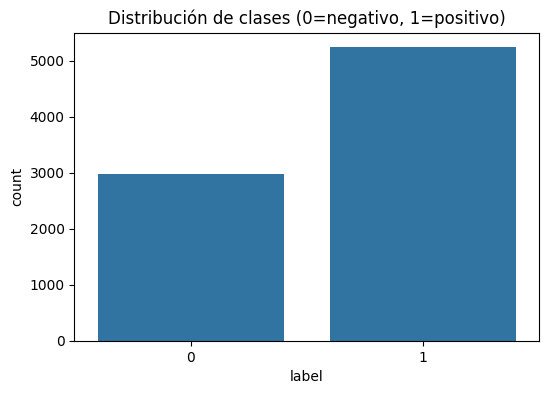

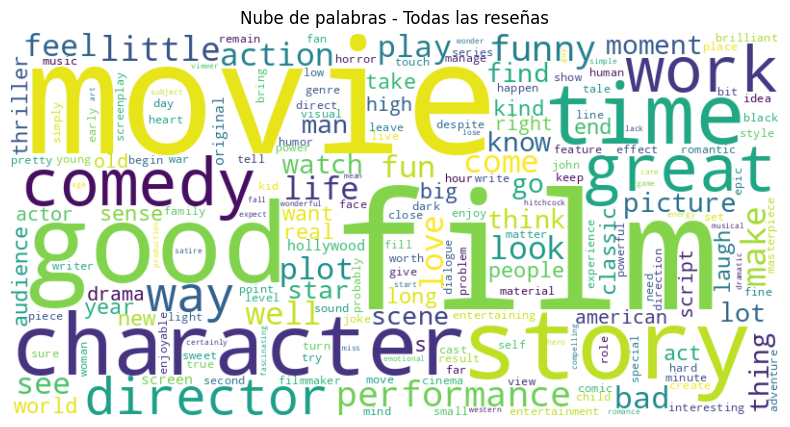

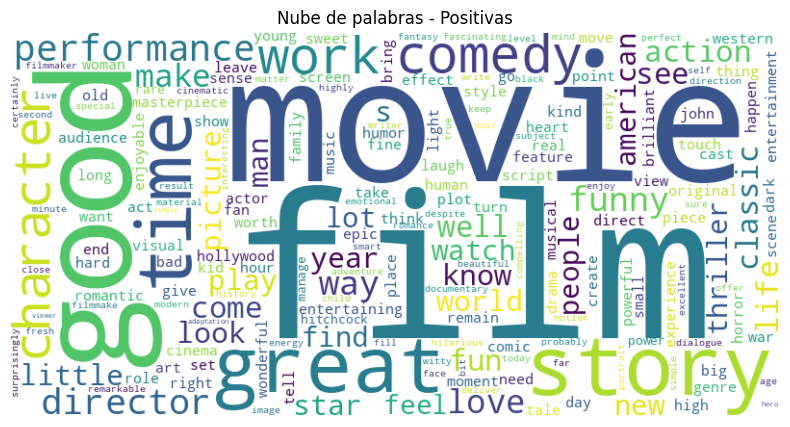

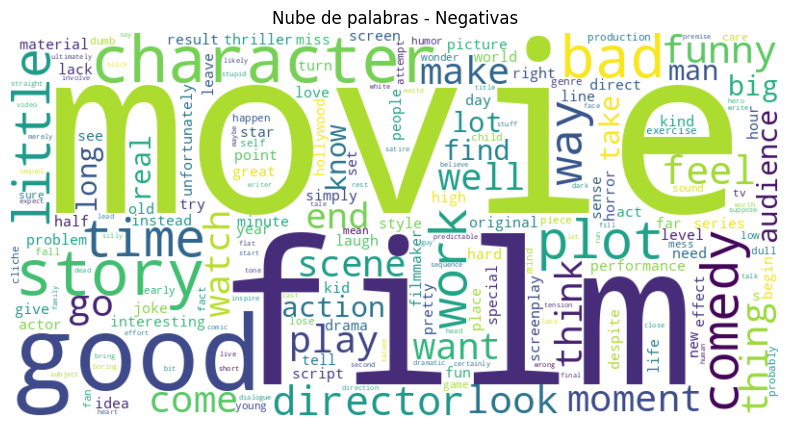

In [16]:
# Longitud en palabras
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))
print(df['word_count'].describe())

# Distribución de clases (etiqueta binaria)
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Distribución de clases (0=negativo, 1=positivo)')
plt.show()

# Nube de palabras global y por clase
all_text = ' '.join(df['lemma_review'].dropna().astype(str))
all_text = all_text.replace('nan', '').strip()
wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Todas las reseñas')
plt.show()

# Por clase
pos_text = ' '.join(df[df['label'] == 1]['lemma_review'].dropna().astype(str))
pos_text = pos_text.replace('nan', '').strip()
neg_text = ' '.join(df[df['label'] == 0]['lemma_review'].dropna().astype(str))
neg_text = neg_text.replace('nan', '').strip()

plt.figure(figsize=(10,5))
wc_pos = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(pos_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Positivas')
plt.show()

plt.figure(figsize=(10,5))
wc_neg = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(neg_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Negativas')
plt.show()

# 8. N-gramas (bigrams más frecuentes)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer


def top_ngrams(corpus, ngram_range=(1,1), n=20):
  vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

print('Top 20 bigrams:')
print(top_ngrams(df['lemma_review'], ngram_range=(2,2), n=20))




Top 20 bigrams:
[('special effect', np.int64(65)), ('motion picture', np.int64(44)), ('good film', np.int64(44)), ('romantic comedy', np.int64(38)), ('good movie', np.int64(37)), ('look like', np.int64(33)), ('movie like', np.int64(33)), ('writer director', np.int64(33)), ('kind movie', np.int64(32)), ('horror film', np.int64(29)), ('feel like', np.int64(29)), ('tell story', np.int64(27)), ('love story', np.int64(27)), ('sci fi', np.int64(26)), ('old fashioned', np.int64(26)), ('film noir', np.int64(26)), ('science fiction', np.int64(24)), ('movie good', np.int64(24)), ('film like', np.int64(23)), ('great film', np.int64(23))]


# 9. Vectorización y modelo (TF-IDF + Regresión Logística)

Entrenando modelo TF-IDF + Regresión Logística...
Entrenamiento finalizado
Accuracy (test): 0.7393422655298416

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.45      0.56       595
           1       0.74      0.90      0.82      1047

    accuracy                           0.74      1642
   macro avg       0.73      0.68      0.69      1642
weighted avg       0.74      0.74      0.72      1642



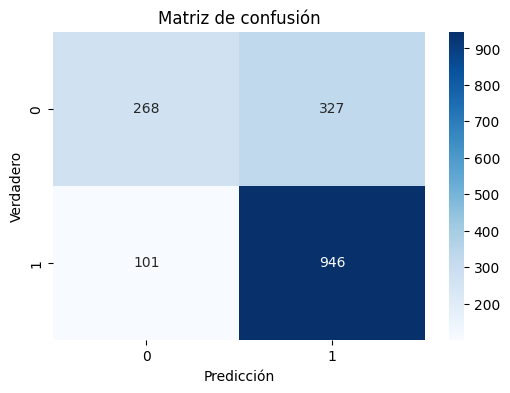

In [18]:
X = df['lemma_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.85, min_df=5)),
('clf', LogisticRegression(max_iter=1000))
])

print('Entrenando modelo TF-IDF + Regresión Logística...')
pipeline.fit(X_train, y_train)
print('Entrenamiento finalizado')

# Evaluación
y_pred = pipeline.predict(X_test)
print('Accuracy (test):', accuracy_score(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión')
plt.show()

# 10. Interpretabilidad: top features del modelo

In [19]:
clf = pipeline.named_steps['clf']
vectorizer = pipeline.named_steps['tfidf']
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]


top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]


print('Top 20 features que inducen POSITIVO:')
for idx in top_pos_idx:
  print(feature_names[idx], round(coefs[idx],4))


print('\nTop 20 features que inducen NEGATIVO:')
for idx in top_neg_idx:
  print(feature_names[idx], round(coefs[idx],4))

Top 20 features que inducen POSITIVO:
great 2.2883
classic 2.1068
masterpiece 2.0818
fun 1.9665
performance 1.9654
rare 1.9454
love 1.9332
powerful 1.8071
remarkable 1.7848
wonderful 1.6614
smart 1.6224
ride 1.6128
highly 1.6106
entertain 1.6017
romantic 1.5812
hitchcock 1.5742
brilliant 1.553
personal 1.5498
perfect 1.5432
musical 1.5335

Top 20 features que inducen NEGATIVO:
bad -3.0787
unfortunately -2.7181
disappointment -2.1494
plot -2.1262
instead -2.0299
waste -2.0111
lack -1.9859
idea -1.9525
boring -1.9359
cliche -1.9345
thin -1.8118
mess -1.7716
unfunny -1.7644
promise -1.7235
try -1.6933
exercise -1.6902
weak -1.671
video -1.6446
dull -1.6286
stupid -1.6232


# 11. Conclusiones

* Se entrenaron y evaluaron modelos de análisis de sentimiento con TF-IDF y Regresión Logística sobre 10k y 50k reseñas.
* El modelo con 10k reseñas obtuvo una accuracy de 0.74, mientras que con 50k reseñas alcanzó 0.78, mostrando una mejora al aumentar el volumen de datos.
* Los términos asociados a sentimientos positivos incluyeron: "fun", "entertaining", "masterpiece", "great" y "wonderful", mientras que los negativos destacaron "fail", "dull", "boring", "waste" y "disappointing".
* Se concluye que el enfoque TF-IDF + Regresión Logística resulta eficaz e interpretable para la clasificación de sentimientos.
* El aumento del tamaño del corpus mejora la capacidad del modelo para generalizar.
* Futuras mejoras podrían incluir el balanceo de clases, el uso de embeddings (Word2Vec, BERT) o redes neuronales.